/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_31920/2457316838.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_shots = pd.concat(all_shots_list, ignore_index=True)
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_31920/2457316838.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_shots['shot_type'] = new_shots.apply(define_shot_type, axis=1)
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_31920/2457316838.py:121: PerformanceWarning: DataFrame is highly fragmented

Saved combined shot data to /Users/user/XG/NWSL/JSON/all_matches_with_danger_scores.csv
Trained model saved to /Users/user/XG/NWSL/JSON/calibrated_logistic_model_new.pkl


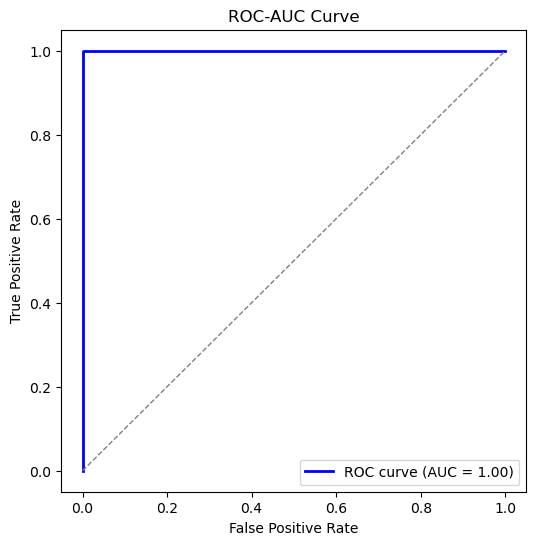

/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_31920/2457316838.py:250: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefs.values, y=coefs.index, palette='viridis')


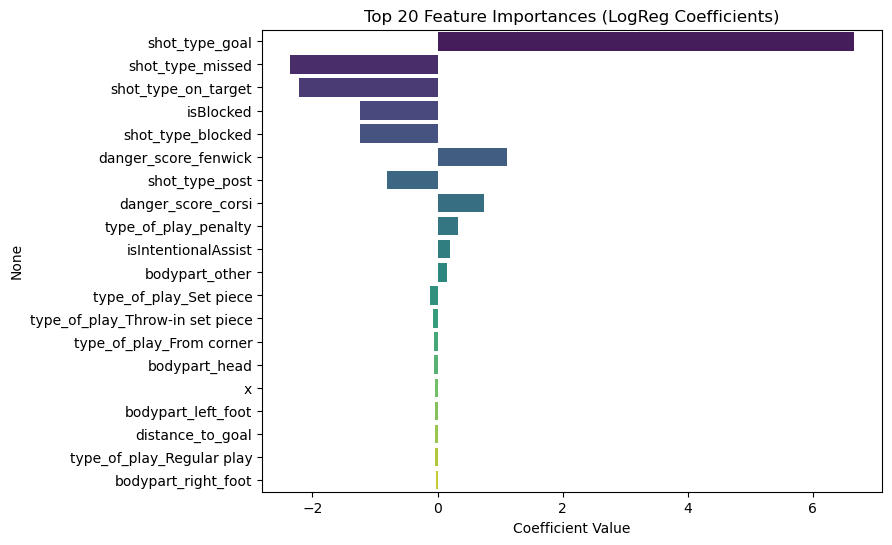

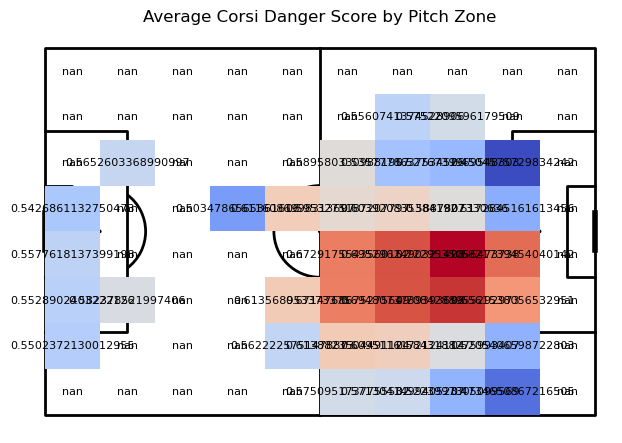

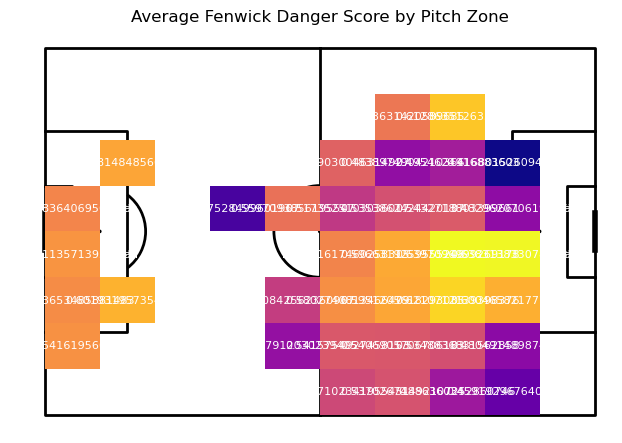

In [2]:
import os
import glob
import json
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from mplsoccer import Pitch
import seaborn as sns

# ---------------------------
# Paths
# ---------------------------
folder_path = '/Users/user/XG/NWSL/JSON'
json_files = glob.glob(os.path.join(folder_path, '*.json'))

# ---------------------------
# Helper functions
# ---------------------------
QUAL_ENDX_ID = 140
QUAL_ENDY_ID = 141

def safe_num(value):
    if isinstance(value, (int, float)):
        return value
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan

def load_json_events(json_path: str) -> pd.DataFrame:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    events = data.get("event", [])
    rows = []
    for e in events:
        row = {
            "id": e.get("id"),
            "eventId": str(e.get("eventId")),
            "typeId": str(e.get("typeId")),
            "periodId": e.get("periodId"),
            "timeMin": e.get("timeMin"),
            "timeSec": e.get("timeSec"),
            "contestantId": str(e.get("contestantId")),
            "playerId": str(e.get("playerId")),
            "playerName": e.get("playerName"),
            "outcome": int(e.get("outcome") or 0),
            "x": safe_num(e.get("x")),
            "y": safe_num(e.get("y")),
            "timeStamp": e.get("timeStamp"),
            "lastModified": e.get("lastModified"),
        }
        for q in e.get("qualifier", []):
            qid = q.get("qualifierId")
            val = q.get("value", 1)
            row[f"qualifier_{qid}"] = val
        rows.append(row)
    df = pd.DataFrame(rows)

    if f"qualifier_{QUAL_ENDX_ID}" in df.columns:
        df["end_x"] = df[f"qualifier_{QUAL_ENDX_ID}"].apply(safe_num)
    else:
        df["end_x"] = np.nan

    if f"qualifier_{QUAL_ENDY_ID}" in df.columns:
        df["end_y"] = df[f"qualifier_{QUAL_ENDY_ID}"].apply(safe_num)
    else:
        df["end_y"] = np.nan

    return df

# ---------------------------
# Load and concatenate all JSONs
# ---------------------------
all_shots_list = []
for json_file_path in json_files:
    df = load_json_events(json_file_path)
    df = df[df['typeId'].isin(['13','14','15','16'])].copy().reset_index(drop=True)
    df['match_file'] = os.path.basename(json_file_path)
    all_shots_list.append(df)

new_shots = pd.concat(all_shots_list, ignore_index=True)

# ---------------------------
# Preprocessing / Features
# ---------------------------
is_blocked = (new_shots['typeId'] == '15') & new_shots.get('qualifier_82', pd.Series(dtype=object)).notna()

def define_shot_type(row):
    if is_blocked.loc[row.name]:
        return 'blocked'
    elif row['typeId'] == '15':
        return 'on_target'
    elif row['typeId'] == '13':
        return 'missed'
    elif row['typeId'] == '14':
        return 'post'
    elif row['typeId'] == '16':
        return 'goal'
    else:
        return 'unknown'

new_shots['shot_type'] = new_shots.apply(define_shot_type, axis=1)

def get_bodypart(row):
    if 'qualifier_15' in row and not pd.isna(row['qualifier_15']):
        return 'head'
    elif 'qualifier_72' in row and not pd.isna(row['qualifier_72']):
        return 'left_foot'
    elif 'qualifier_20' in row and not pd.isna(row['qualifier_20']):
        return 'right_foot'
    elif 'qualifier_21' in row and not pd.isna(row['qualifier_21']):
        return 'other'
    else:
        return 'unknown'

new_shots['bodypart'] = new_shots.apply(get_bodypart, axis=1)

play_types = {
    '22':'Regular play','23':'Fast break','24':'Set piece','25':'From corner',
    '26':'Free kick','160':'Throw-in set piece','9':'penalty'
}

def get_type_of_play(row):
    for qid, q_name in play_types.items():
        if f'qualifier_{qid}' in row and not pd.isna(row[f'qualifier_{qid}']):
            return q_name
    return 'unknown'

new_shots['type_of_play'] = new_shots.apply(get_type_of_play, axis=1)

def calc_distance_angle(x,y,goal_x=100,goal_y=50):
    dx = goal_x - x
    dy = goal_y - y
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy,dx)
    return distance, np.abs(np.degrees(angle))

new_shots[['distance_to_goal','angle_to_goal']] = new_shots.apply(
    lambda row: pd.Series(calc_distance_angle(row['x'], row['y'])), axis=1)

# ---------------------------
# Fenwick & Corsi ratios
# ---------------------------
fenwick_attempts = new_shots[new_shots['shot_type']!='blocked']
fenwick_for = fenwick_attempts.groupby('contestantId').size().reset_index(name='fenwick_for')
total_fenwicks = fenwick_attempts.shape[0]
fenwick_for['fenwick_ratio'] = fenwick_for['fenwick_for'] / total_fenwicks

corsi_for = new_shots.groupby('contestantId').size().reset_index(name='corsi_for')
total_corsis = new_shots.shape[0]
corsi_for['corsi_ratio'] = corsi_for['corsi_for'] / total_corsis

new_shots = new_shots.merge(fenwick_for[['contestantId','fenwick_ratio']], on='contestantId', how='left')
new_shots = new_shots.merge(corsi_for[['contestantId','corsi_ratio']], on='contestantId', how='left')

# ---------------------------
# Shot weights & danger scores
# ---------------------------
shot_type_weights = {'goal':1.2,'on_target':1.0,'post':0.7,'missed':0.5,'blocked':0.3,'unknown':0.1}
new_shots['shot_type_weight'] = new_shots['shot_type'].map(shot_type_weights).fillna(0)
new_shots['inv_distance'] = 1 - (new_shots['distance_to_goal']/100)
new_shots['angle_score'] = 1 - (new_shots['angle_to_goal']/90)

new_shots['danger_score_fenwick'] = (
    0.3*new_shots['inv_distance'] + 0.2*new_shots['angle_score'] +
    0.3*new_shots['shot_type_weight'] + 0.2*new_shots['fenwick_ratio']
)
new_shots['danger_score_corsi'] = (
    0.4*new_shots['inv_distance'] + 0.3*new_shots['angle_score'] +
    0.2*new_shots['shot_type_weight'] + 0.1*new_shots['corsi_ratio']
)

new_shots['isIntentionalAssist'] = new_shots.get('qualifier_154',0).apply(lambda x:1 if x==1 else 0)
new_shots['RelatedPlayerId'] = new_shots.get('qualifier_55', np.nan).fillna(-1).astype(int)
new_shots['isGoal'] = new_shots['typeId']=='16'
new_shots['isBlocked'] = is_blocked

# ---------------------------
# Features & target
# ---------------------------
categorical = ['shot_type','bodypart','type_of_play']
numerical = ['isIntentionalAssist','RelatedPlayerId',
             'danger_score_fenwick','danger_score_corsi','x','y',
             'distance_to_goal','angle_to_goal','isBlocked']

X_cat = pd.get_dummies(new_shots[categorical], dummy_na=True)
X_num = new_shots[numerical]
X_all = pd.concat([X_cat,X_num],axis=1)
y = new_shots['isGoal'].astype(int)

# ---------------------------
# Train-test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.3, random_state=42)

# ---------------------------
# Train new calibrated logistic model
# ---------------------------
logreg = LogisticRegression(max_iter=5000)
model = CalibratedClassifierCV(logreg, method='sigmoid', cv=5)
model.fit(X_train, y_train)

# ---------------------------
# Predict danger scores
# ---------------------------
danger_scores = model.predict_proba(X_all)[:,1]
new_shots['danger_score_logit'] = ((danger_scores - danger_scores.min()) / (danger_scores.max() - danger_scores.min()))*100

# ---------------------------
# Save combined data & model
# ---------------------------
output_csv = os.path.join(folder_path,'all_matches_with_danger_scores.csv')
new_shots.to_csv(output_csv,index=False)
print(f"Saved combined shot data to {output_csv}")

model_path = os.path.join(folder_path,'calibrated_logistic_model_new.pkl')
joblib.dump(model, model_path)
print(f"Trained model saved to {model_path}")

# ---------------------------
# ROC-AUC Curve
# ---------------------------
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,y_pred_proba)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,color='blue',lw=2,label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],color='grey',lw=1,linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

# Train uncalibrated LogisticRegression for coefficients
logreg_for_coef = LogisticRegression(max_iter=5000)
logreg_for_coef.fit(X_train, y_train)

# Feature importance
coefs = pd.Series(logreg_for_coef.coef_[0], index=X_all.columns)
coefs = coefs.sort_values(key=abs, ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=coefs.values, y=coefs.index, palette='viridis')
plt.title('Top 20 Feature Importances (LogReg Coefficients)')
plt.xlabel('Coefficient Value')
plt.show()


# ---------------------------
# Pitch Heatmaps
# ---------------------------
pitch = Pitch(pitch_type='statsbomb',pitch_color='white',line_color='black')

bin_stat_corsi = pitch.bin_statistic(new_shots['x'],new_shots['y'],statistic='mean',
                                     bins=(10,8),values=new_shots['danger_score_corsi'])
fig,ax = pitch.draw()
pitch.heatmap(bin_stat_corsi,ax=ax,cmap='coolwarm')
pitch.label_heatmap(bin_stat_corsi,ax=ax,color='black',fontsize=8)
plt.title('Average Corsi Danger Score by Pitch Zone')
plt.show()

bin_stat_fenwick = pitch.bin_statistic(new_shots['x'],new_shots['y'],statistic='mean',
                                      bins=(10,8),values=new_shots['danger_score_fenwick'])
fig,ax = pitch.draw()
pitch.heatmap(bin_stat_fenwick,ax=ax,cmap='plasma')
pitch.label_heatmap(bin_stat_fenwick,ax=ax,color='white',fontsize=8)
plt.title('Average Fenwick Danger Score by Pitch Zone')
plt.show()


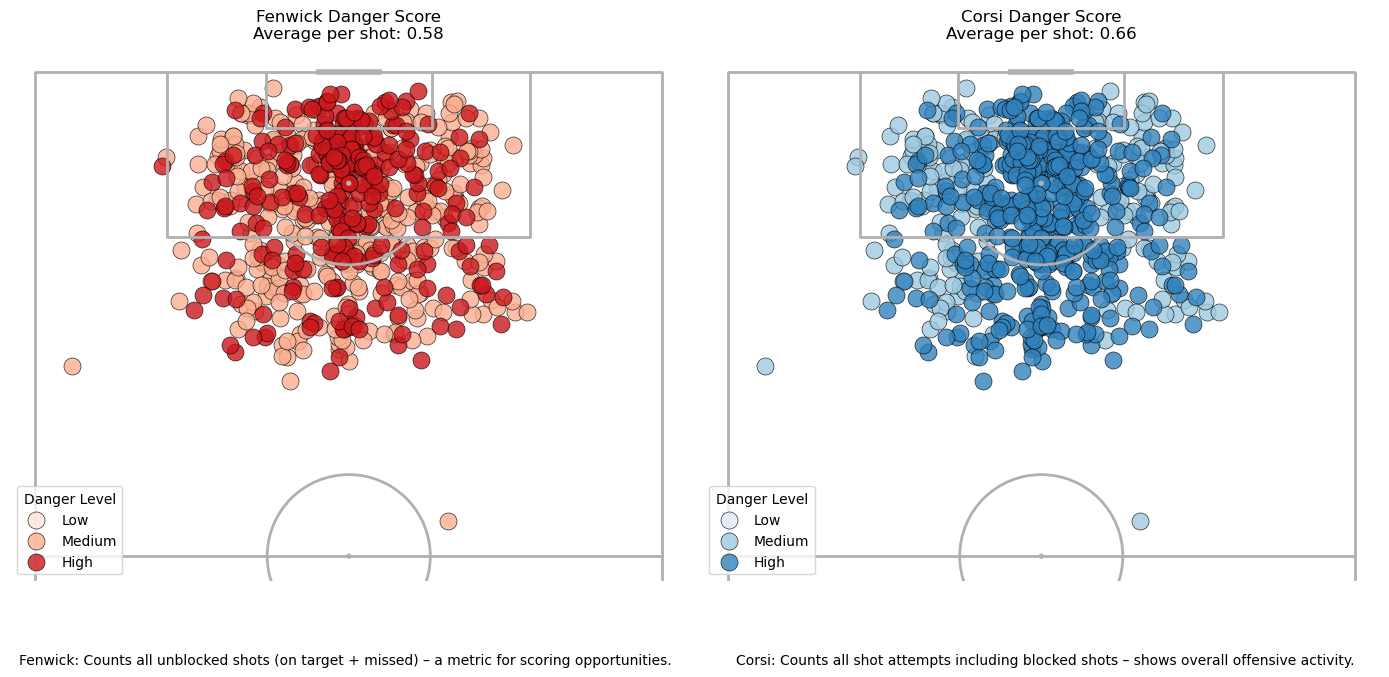

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
import numpy as np

# --- Load CSV ---
file_path = "/Users/user/XG/Eredivisie 2025-2026/all_matches_with_danger_scores.csv"
df = pd.read_csv(file_path)

# --- Compute averages ---
avg_fenwick = df['danger_score_fenwick'].mean()
avg_corsi = df['danger_score_corsi'].mean()

# --- Define bins ---
bins = [0, 0.3, 0.6, 1]  # Adjust based on your danger score range
labels = ['Low', 'Medium', 'High']

df['fenwick_bin'] = pd.cut(df['danger_score_fenwick'], bins=bins, labels=labels, include_lowest=True)
df['corsi_bin'] = pd.cut(df['danger_score_corsi'], bins=bins, labels=labels, include_lowest=True)

# Define colors for bins
color_map_fenwick = {'Low':'#fee5d9','Medium':'#fcae91','High':'#cb181d'}
color_map_corsi = {'Low':'#deebf7','Medium':'#9ecae1','High':'#3182bd'}

# --- Create figure and axes ---
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# --- Create vertical half-pitches ---
pitch1 = VerticalPitch(half=True, pitch_type='opta', line_zorder=2)
pitch2 = VerticalPitch(half=True, pitch_type='opta', line_zorder=2)

# Draw pitches
pitch1.draw(ax=axs[0])
pitch2.draw(ax=axs[1])

# --- Plot Fenwick danger score ---
for bin_label, color in color_map_fenwick.items():
    subset = df[df['fenwick_bin'] == bin_label]
    pitch1.scatter(
        subset['x'], subset['y'],
        c=color,
        edgecolors='black',
        linewidth=0.5,
        s=150,
        alpha=0.8,
        ax=axs[0],
        label=bin_label
    )
# Legend bottom left
axs[0].legend(title='Danger Level', loc='lower left')
axs[0].set_title(f'Fenwick Danger Score\nAverage per shot: {avg_fenwick:.2f}')

# --- Plot Corsi danger score ---
for bin_label, color in color_map_corsi.items():
    subset = df[df['corsi_bin'] == bin_label]
    pitch2.scatter(
        subset['x'], subset['y'],
        c=color,
        edgecolors='black',
        linewidth=0.5,
        s=150,
        alpha=0.8,
        ax=axs[1],
        label=bin_label
    )
# Legend bottom left
axs[1].legend(title='Danger Level', loc='lower left')
axs[1].set_title(f'Corsi Danger Score\nAverage per shot: {avg_corsi:.2f}')

# --- Add explanatory text directly under the pitches ---
fig.text(0.25, 0.05, 
         "Fenwick: Counts all unblocked shots (on target + missed) – a metric for scoring opportunities.",
         fontsize=10, ha='center')
fig.text(0.75, 0.05, 
         "Corsi: Counts all shot attempts including blocked shots – shows overall offensive activity.",
         fontsize=10, ha='center')

plt.tight_layout(rect=[0, 0.1, 1, 1])  # leave space at the bottom for text

# --- Save figure as PNG ---
fig.savefig("/Users/user/Downloads/xDanger/CorsiFenwick.png", dpi=300, bbox_inches='tight')

# --- Display figure ---
plt.show()


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_1193/2513260110.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blocked_df['corsi_bin'] = pd.cut(blocked_df['danger_score_corsi'], bins=bins, labels=labels, include_lowest=True)


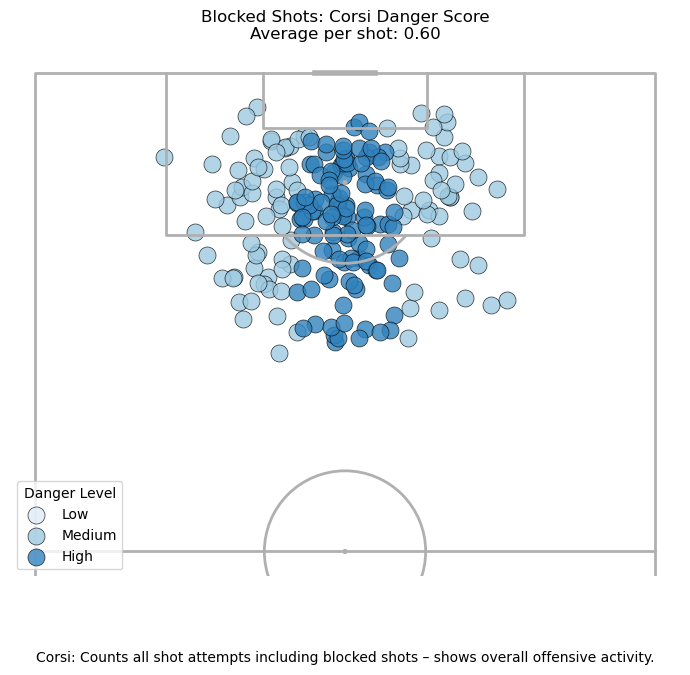

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
import numpy as np

# --- Load CSV ---
file_path = "/Users/user/XG/Eredivisie 2025-2026/all_matches_with_danger_scores.csv"
df = pd.read_csv(file_path)

# --- Filter only blocked shots ---
blocked_df = df[df['isBlocked'] == True]

# --- Compute average Corsi danger score for blocked shots ---
avg_corsi_blocked = blocked_df['danger_score_corsi'].mean()

# --- Define bins for danger score ---
bins = [0, 0.3, 0.6, 1]  # adjust according to your danger score range
labels = ['Low', 'Medium', 'High']
blocked_df['corsi_bin'] = pd.cut(blocked_df['danger_score_corsi'], bins=bins, labels=labels, include_lowest=True)

# Define colors for bins
color_map_corsi = {'Low':'#deebf7','Medium':'#9ecae1','High':'#3182bd'}

# --- Create figure and axis ---
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# --- Create vertical half-pitch ---
pitch = VerticalPitch(half=True, pitch_type='opta', line_zorder=2)
pitch.draw(ax=ax)

# --- Plot Corsi danger score for blocked shots ---
for bin_label, color in color_map_corsi.items():
    subset = blocked_df[blocked_df['corsi_bin'] == bin_label]
    pitch.scatter(
        subset['x'], subset['y'],
        c=color,
        edgecolors='black',
        linewidth=0.5,
        s=150,
        alpha=0.8,
        ax=ax,
        label=bin_label
    )

# Legend bottom left
ax.legend(title='Danger Level', loc='lower left')

# Title with average Corsi danger score
ax.set_title(f'Blocked Shots: Corsi Danger Score\nAverage per shot: {avg_corsi_blocked:.2f}')

# --- Add explanatory text directly under the pitch ---
fig.text(0.5, 0.05, 
         "Corsi: Counts all shot attempts including blocked shots – shows overall offensive activity.",
         fontsize=10, ha='center')

# Adjust layout to leave space at the bottom for text
plt.tight_layout(rect=[0, 0.1, 1, 1])

# --- Save figure as PNG ---
fig.savefig("/Users/user/Downloads/xDanger/BlockedShots_Corsi.png", dpi=300, bbox_inches='tight')

# Display figure
plt.show()


In [1]:
import os
import glob
import json
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
import joblib

# ---------------------------
# Paths
# ---------------------------
folder_path = '/Users/user/XG/Brazil'
json_files = glob.glob(os.path.join(folder_path, '*.json'))

# ---------------------------
# Helper functions
# ---------------------------
QUAL_ENDX_ID = 140
QUAL_ENDY_ID = 141
QUAL_BLOCKX_ID = 146
QUAL_BLOCKY_ID = 147


def safe_num(value):
    if isinstance(value, (int, float)):
        return value
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan


def load_json_events(json_path: str) -> pd.DataFrame:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    events = data.get("event", [])
    rows = []
    for e in events:
        row = {
            "id": e.get("id"),
            "eventId": str(e.get("eventId")),
            "typeId": str(e.get("typeId")),
            "periodId": e.get("periodId"),
            "timeMin": e.get("timeMin"),
            "timeSec": e.get("timeSec"),
            "contestantId": str(e.get("contestantId")),
            "playerId": str(e.get("playerId")),
            "playerName": e.get("playerName"),
            "outcome": int(e.get("outcome") or 0),
            "x": safe_num(e.get("x")),
            "y": safe_num(e.get("y")),
            "timeStamp": e.get("timeStamp"),
            "lastModified": e.get("lastModified"),
        }
        for q in e.get("qualifier", []):
            qid = q.get("qualifierId")
            val = q.get("value", 1)
            row[f"qualifier_{qid}"] = val
        rows.append(row)
    df = pd.DataFrame(rows)

    # shot end locations
    if f"qualifier_{QUAL_ENDX_ID}" in df.columns:
        df["end_x"] = df[f"qualifier_{QUAL_ENDX_ID}"].apply(safe_num)
    else:
        df["end_x"] = np.nan

    if f"qualifier_{QUAL_ENDY_ID}" in df.columns:
        df["end_y"] = df[f"qualifier_{QUAL_ENDY_ID}"].apply(safe_num)
    else:
        df["end_y"] = np.nan

    # block locations
    if f"qualifier_{QUAL_BLOCKX_ID}" in df.columns:
        df["block_x"] = df[f"qualifier_{QUAL_BLOCKX_ID}"].apply(safe_num)
    else:
        df["block_x"] = np.nan

    if f"qualifier_{QUAL_BLOCKY_ID}" in df.columns:
        df["block_y"] = df[f"qualifier_{QUAL_BLOCKY_ID}"].apply(safe_num)
    else:
        df["block_y"] = np.nan

    return df


# ---------------------------
# Load and filter shots
# ---------------------------
all_shots_list = []
for json_file_path in json_files:
    df = load_json_events(json_file_path)
    df = df[df['typeId'].isin(['13','14','15','16'])].copy().reset_index(drop=True)
    df['match_file'] = os.path.basename(json_file_path)
    all_shots_list.append(df)

new_shots = pd.concat(all_shots_list, ignore_index=True)

# ---------------------------
# Shot type + features
# ---------------------------
is_blocked = (new_shots['typeId'] == '15') & new_shots['block_x'].notna()


def define_shot_type(row):
    if is_blocked.loc[row.name]:
        return 'blocked'
    elif row['typeId'] == '15':
        return 'on_target'
    elif row['typeId'] == '13':
        return 'missed'
    elif row['typeId'] == '14':
        return 'post'
    elif row['typeId'] == '16':
        return 'goal'
    else:
        return 'unknown'


new_shots['shot_type'] = new_shots.apply(define_shot_type, axis=1)


def calc_distance_angle(x, y, goal_x=100, goal_y=50):
    dx = goal_x - x
    dy = goal_y - y
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx)
    return distance, np.abs(np.degrees(angle))


new_shots[['distance_to_goal','angle_to_goal']] = new_shots.apply(
    lambda row: pd.Series(calc_distance_angle(row['x'], row['y'])), axis=1)

# ---------------------------
# Normalize corsi danger score 0-1
# ---------------------------
shot_type_weights = {'goal':1.2,'on_target':1.0,'post':0.7,'missed':0.5,'blocked':0.3,'unknown':0.1}
new_shots['shot_type_weight'] = new_shots['shot_type'].map(shot_type_weights).fillna(0)
new_shots['inv_distance'] = 1 - (new_shots['distance_to_goal']/100)
new_shots['angle_score'] = 1 - (new_shots['angle_to_goal']/90)

new_shots['danger_score_corsi'] = (
    0.4*new_shots['inv_distance'] + 0.3*new_shots['angle_score'] +
    0.2*new_shots['shot_type_weight']
)

# scale to 0–1
new_shots['danger_score_corsi'] = (
    (new_shots['danger_score_corsi'] - new_shots['danger_score_corsi'].min()) /
    (new_shots['danger_score_corsi'].max() - new_shots['danger_score_corsi'].min())
)

new_shots['isGoal'] = new_shots['typeId']=='16'
new_shots['isBlocked'] = is_blocked

# ---------------------------
# Train model for block danger
# ---------------------------
X = new_shots[['x','y','inv_distance','angle_score','shot_type_weight']].fillna(0)
y = new_shots['isGoal'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg = LogisticRegression(max_iter=5000)
model = CalibratedClassifierCV(logreg, method='sigmoid', cv=5)
model.fit(X_train, y_train)

# ---------------------------
# Compute danger for blocked shots
# ---------------------------
blocked_shots = new_shots[new_shots['isBlocked']].copy()

# Features for shot locations
danger_shot = blocked_shots['danger_score_corsi']

# Features for block locations
block_features = pd.DataFrame({
    'x': blocked_shots['block_x'],
    'y': blocked_shots['block_y'],
    'inv_distance': 1 - (np.sqrt((100 - blocked_shots['block_x'])**2 + (50 - blocked_shots['block_y'])**2)/100),
    'angle_score': 1 - (np.abs(np.degrees(np.arctan2(50 - blocked_shots['block_y'], 100 - blocked_shots['block_x'])))/90),
    'shot_type_weight': blocked_shots['shot_type_weight']
}).fillna(0)

block_danger_raw = model.predict_proba(block_features)[:,1]

# Save into df
blocked_shots['danger_score_shot'] = danger_shot
blocked_shots['danger_score_block'] = block_danger_raw
blocked_shots['danger_prevented'] = blocked_shots['danger_score_shot'] - blocked_shots['danger_score_block']

# ---------------------------
# Save to Excel
# ---------------------------
output_excel = os.path.join(folder_path,'blocked_shots_danger.xlsx')
cols_to_save = ['id','playerName','x','y','block_x','block_y','danger_score_shot','danger_score_block','danger_prevented']
blocked_shots[cols_to_save].to_excel(output_excel, index=False)

print(f"Blocked shots with danger prevented saved to {output_excel}")


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_72535/2202948954.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_shots = pd.concat(all_shots_list, ignore_index=True)
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_72535/2202948954.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_shots['shot_type'] = new_shots.apply(define_shot_type, axis=1)
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_72535/2202948954.py:133: PerformanceWarning: DataFrame is highly fragmented

Blocked shots with danger prevented saved to /Users/user/XG/Brazil/blocked_shots_danger.xlsx


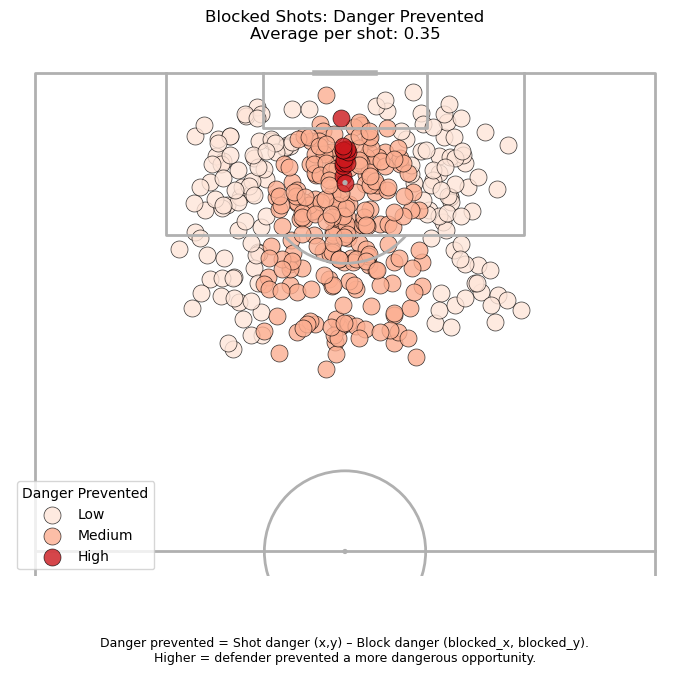

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
import numpy as np

# --- Load Excel with blocked shots + danger prevented ---
file_path = "/Users/user/XG/Eredivisie 2025-2026/blocked_shots_danger.xlsx"
df = pd.read_excel(file_path)

# --- Compute average danger prevented ---
avg_danger_prevented = df['danger_prevented'].mean()

# --- Define bins for danger prevented ---
bins = [0, 0.3, 0.6, 1]  # scale is already 0-1
labels = ['Low', 'Medium', 'High']
df['prevented_bin'] = pd.cut(df['danger_prevented'], bins=bins, labels=labels, include_lowest=True)

# --- Define colors for bins ---
color_map_prevented = {'Low':'#fee5d9','Medium':'#fcae91','High':'#cb181d'}

# --- Create figure and axis ---
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# --- Create vertical half-pitch ---
pitch = VerticalPitch(half=True, pitch_type='opta', line_zorder=2)
pitch.draw(ax=ax)

# --- Plot danger prevented ---
for bin_label, color in color_map_prevented.items():
    subset = df[df['prevented_bin'] == bin_label]
    pitch.scatter(
        subset['x'], subset['y'],  # shot location
        c=color,
        edgecolors='black',
        linewidth=0.5,
        s=150,
        alpha=0.8,
        ax=ax,
        label=bin_label
    )

# Legend bottom left
ax.legend(title='Danger Prevented', loc='lower left')

# Title with average danger prevented
ax.set_title(f'Blocked Shots: Danger Prevented\nAverage per shot: {avg_danger_prevented:.2f}')

# --- Add explanatory text directly under the pitch ---
fig.text(0.5, 0.05, 
         "Danger prevented = Shot danger (x,y) – Block danger (blocked_x, blocked_y).\n"
         "Higher = defender prevented a more dangerous opportunity.",
         fontsize=9, ha='center')

# Adjust layout to leave space at the bottom for text
plt.tight_layout(rect=[0, 0.1, 1, 1])

# --- Save figure as PNG ---
fig.savefig("/Users/user/Downloads/xDanger/BlockedShots_DangerPrevented.png", dpi=300, bbox_inches='tight')

# Display figure
plt.show()


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_1193/2911781631.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events['order_key'] = (


Saved pass network edges to /Users/user/XG/Eredivisie 2025-2026/pass_network_edges.csv
Saved pass network nodes to /Users/user/XG/Eredivisie 2025-2026/pass_network_nodes.csv
Saved expected danger chains to /Users/user/XG/Eredivisie 2025-2026/expected_danger_chains.csv
Saved pass network plot to /Users/user/XG/Eredivisie 2025-2026/pass_network_team_24fvcruwqrqvqa3aonf8c3zuy.png


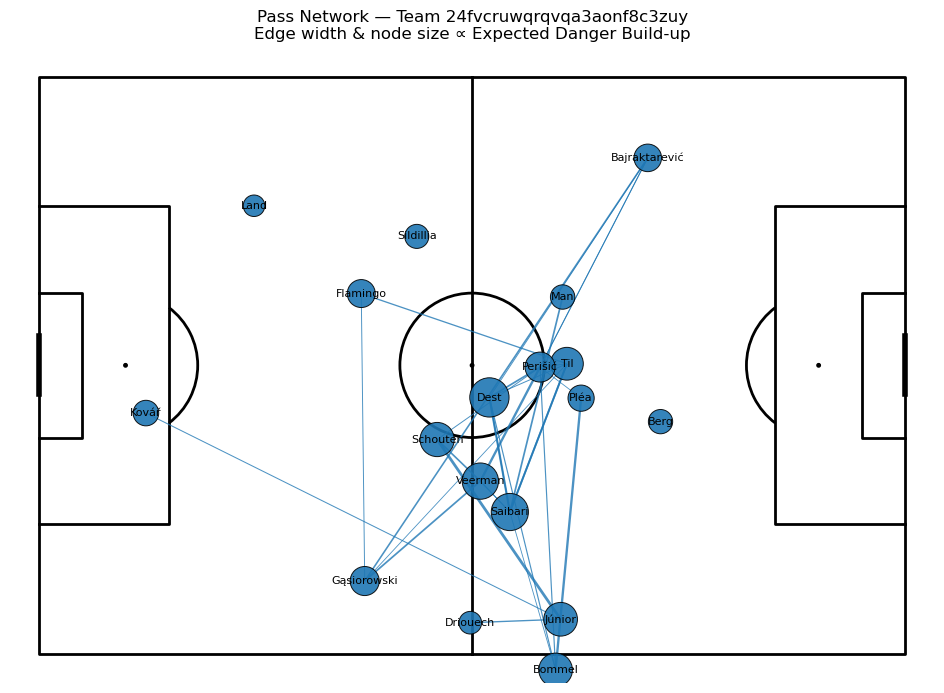

In [37]:
# ============================================================
# PASS NETWORK with Expected Danger Build-up & Chains
# ============================================================
from mplsoccer import Pitch

# -------- Reload ALL events (not only shots) --------
all_events_list = []
for json_file_path in json_files:
    df_all = load_json_events(json_file_path)  # same helper you already have
    df_all['match_file'] = os.path.basename(json_file_path)
    all_events_list.append(df_all)

events = pd.concat(all_events_list, ignore_index=True)

# Basic ordering for sequence logic
events['timeMin'] = pd.to_numeric(events['timeMin'], errors='coerce').fillna(0).astype(int)
events['timeSec'] = pd.to_numeric(events['timeSec'], errors='coerce').fillna(0).astype(int)
events['order_key'] = (
    events['match_file'].astype(str) + '_' +
    events['periodId'].astype(str) + '_' +
    events['timeMin'].astype(str).str.zfill(3) + '_' +
    events['timeSec'].astype(str).str.zfill(2) + '_' +
    events.index.astype(str)
)
events = events.sort_values(['match_file', 'periodId', 'timeMin', 'timeSec']).reset_index(drop=True)

# -------- Identify passes & shots --------
PASS_TYPE = '1'                              # Opta pass
SHOT_TYPES = set(['13','14','15','16'])     # your shot set
events['is_pass'] = (events['typeId'] == PASS_TYPE) & (events['outcome'] == 1)
events['is_shot'] = events['typeId'].isin(SHOT_TYPES)

# Ensure we have coords
for c in ['x','y','end_x','end_y']:
    if c not in events.columns:
        events[c] = np.nan
events['x'] = events['x'].astype(float)
events['y'] = events['y'].astype(float)
events['end_x'] = events['end_x'].astype(float)
events['end_y'] = events['end_y'].astype(float)

# -------- Possession heuristic: new possession whenever team changes --------
events['new_possession'] = (events['contestantId'] != events['contestantId'].shift(1)) | \
                           (events['periodId'] != events['periodId'].shift(1)) | \
                           (events['match_file'] != events['match_file'].shift(1))
events['possession_id'] = events['new_possession'].cumsum()

# -------- Get shot danger (0–1) from your saved CSV --------
danger_csv_path = os.path.join(folder_path, 'all_matches_with_danger_scores.csv')
danger_df = pd.read_csv(danger_csv_path)

# Map shot danger by (match_file, id) if available; fallback by near-time match if id isn’t aligned
# First try a direct merge on (match_file, id)
shot_cols = ['id','match_file','danger_score_corsi']
if 'match_file' not in danger_df.columns and 'match_file' in events.columns:
    # if earlier pipeline saved match_file, great; else just merge on id
    shot_cols = ['id','danger_score_corsi']

shot_map = danger_df[shot_cols].copy()
# Normalize danger_score_corsi to 0–1 if not already
if shot_map['danger_score_corsi'].max() > 1.0:
    smin, smax = shot_map['danger_score_corsi'].min(), shot_map['danger_score_corsi'].max()
    shot_map['danger_score_corsi'] = (shot_map['danger_score_corsi'] - smin) / (smax - smin + 1e-9)

if 'match_file' in shot_cols:
    events = events.merge(shot_map, on=['id','match_file'], how='left', suffixes=('',''))
else:
    events = events.merge(shot_map, on='id', how='left')

# -------- Build chains that end in a shot --------
# For each possession, if it ends with a shot by same team, attribute that shot's danger to each prior successful pass
chains = []
pass_edges = []  # (match_file, team, passerId, receiverId, passerName, receiverName, x, y, end_x, end_y, danger_contrib)

# Helper to push a chain
def push_chain(df_pos):
    # df_pos is events in one possession_id
    team = str(df_pos['contestantId'].iloc[0])
    match_file = df_pos['match_file'].iloc[0]
    # Last event shot by same team?
    last = df_pos.iloc[-1]
    if not (last['is_shot'] and str(last['contestantId']) == team):
        return
    shot_danger = last.get('danger_score_corsi', np.nan)
    if pd.isna(shot_danger):
        return
    # All successful passes in the possession (by same team)
    df_pass = df_pos[df_pos['is_pass']].copy()
    if df_pass.empty:
        return
    # Attribute danger equally to passes (simple, robust)
    per_pass_contrib = float(shot_danger) / len(df_pass)
    # Determine receivers as the next same-team event (best guess)
    idxs = df_pass.index.to_list()
    for i in idxs:
        # receiver: next event by same team inside this possession
        df_after = df_pos.loc[i+1:]
        receiver_row = df_after[df_after['contestantId'] == team].head(1)
        if receiver_row.empty:
            continue
        receiver = receiver_row.iloc[0]
        passer = df_pos.loc[i]
        pass_edges.append({
            'match_file': match_file,
            'team': team,
            'passerId': str(passer.get('playerId')),
            'passerName': passer.get('playerName'),
            'receiverId': str(receiver.get('playerId')),
            'receiverName': receiver.get('playerName'),
            'x': passer.get('x', np.nan),
            'y': passer.get('y', np.nan),
            'end_x': passer.get('end_x', np.nan),
            'end_y': passer.get('end_y', np.nan),
            'danger_contrib': per_pass_contrib
        })
    # Save chain summary
    chains.append({
        'match_file': match_file,
        'team': team,
        'possession_id': int(df_pos['possession_id'].iloc[0]),
        'n_events': int(len(df_pos)),
        'n_passes': int(df_pass.shape[0]),
        'shot_id': last.get('id'),
        'shot_player': last.get('playerName'),
        'shot_danger': float(shot_danger)
    })

# Iterate possessions per match/period for stability
for (mfile, pid), df_grp in events.groupby(['match_file', 'possession_id'], sort=False):
    push_chain(df_grp.reset_index(drop=True))

chains_df = pd.DataFrame(chains)
edges_df = pd.DataFrame(pass_edges)

# If nothing found, stop gracefully
if edges_df.empty:
    print("No pass edges found that lead to shots with known danger. Check that your CSV had matching shot IDs.")
else:
    # -------- Aggregate edges: counts + total expected danger build-up --------
    agg_edges = (
        edges_df.groupby(['team','passerId','passerName','receiverId','receiverName'], dropna=False)
        .agg(
            passes=('danger_contrib','size'),
            xd_build=('danger_contrib','sum')
        )
        .reset_index()
    )

    # -------- Node positions: average pass start location + totals --------
    node_positions = (
        edges_df.groupby(['team','passerId','passerName'], dropna=False)
        .agg(
            x=('x','mean'),
            y=('y','mean'),
            passes=('danger_contrib','size'),
            xd_build=('danger_contrib','sum')
        )
        .reset_index()
    )

    # -------- Save CSVs --------
    edges_csv = os.path.join(folder_path, 'pass_network_edges.csv')
    nodes_csv = os.path.join(folder_path, 'pass_network_nodes.csv')
    chains_csv = os.path.join(folder_path, 'expected_danger_chains.csv')
    agg_edges.to_csv(edges_csv, index=False)
    node_positions.to_csv(nodes_csv, index=False)
    chains_df.to_csv(chains_csv, index=False)
    print(f"Saved pass network edges to {edges_csv}")
    print(f"Saved pass network nodes to {nodes_csv}")
    print(f"Saved expected danger chains to {chains_csv}")

    # -------- Plot pass network on a pitch --------
    # Choose a team to visualize (contestantId). Set to None for top 1 by passes.
    TEAM_FILTER = None  # e.g., '1234'

    plot_nodes = node_positions.copy()
    plot_edges = agg_edges.copy()

    if TEAM_FILTER is None:
        # Pick the team with most passes
        top_team = (
            plot_nodes.groupby('team')['passes'].sum().sort_values(ascending=False).index[0]
        )
        TEAM_FILTER = top_team

    plot_nodes = plot_nodes[plot_nodes['team'] == TEAM_FILTER].copy()
    plot_edges = plot_edges[plot_edges['team'] == TEAM_FILTER].copy()

    # Keep top edges for clarity
    plot_edges = plot_edges.sort_values('xd_build', ascending=False).head(30).copy()

    # Build mapping id->(x,y) for plotting lines
    pos_map = dict(zip(
        zip(plot_nodes['passerId'], plot_nodes['passerName']),
        zip(plot_nodes['x'], plot_nodes['y'])
    ))
    # Also allow receiver lookup by id+name
    recv_map = dict(zip(
        zip(plot_nodes['passerId'], plot_nodes['passerName']),
        zip(plot_nodes['x'], plot_nodes['y'])
    ))

    # Prepare figure
    pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='black')
    fig, ax = pitch.draw(figsize=(10, 7))

    # Node sizes by xd_build (min-max scaled)
    if not plot_nodes.empty:
        ns = plot_nodes['xd_build'].to_numpy()
        ns = (ns - ns.min()) / (ns.max() - ns.min() + 1e-9)
        node_sizes = 800 * (0.3 + 0.7*ns)  # readable sizes

        pitch.scatter(
            plot_nodes['x'], plot_nodes['y'],
            s=node_sizes, ax=ax, edgecolors='black', linewidth=0.7, alpha=0.9, zorder=3
        )

        for _, r in plot_nodes.iterrows():
            ax.text(r['x'], r['y'], str(r['passerName']).split()[-1], ha='center', va='center',
                    fontsize=8, zorder=4)

    # Edge widths by xd_build (min-max scaled)
    if not plot_edges.empty:
        ew = plot_edges['xd_build'].to_numpy()
        ew = (ew - ew.min()) / (ew.max() - ew.min() + 1e-9)
        widths = 2.0 * (0.3 + 0.7*ew)

        for idx, row in plot_edges.iterrows():
            # Find start (passer) and end (receiver) avg positions
            # We match by (id, name) to be safe across matches
            pkey = (row['passerId'], row['passerName'])
            rkey = (row['receiverId'], row['receiverName'])
            if pkey not in pos_map or rkey not in recv_map:
                # fall back to searching by id only
                ppos = plot_nodes.loc[plot_nodes['passerId'] == row['passerId'], ['x','y']]
                rpos = plot_nodes.loc[plot_nodes['passerId'] == row['receiverId'], ['x','y']]
                if ppos.empty or rpos.empty:
                    continue
                x_start, y_start = float(ppos.iloc[0]['x']), float(ppos.iloc[0]['y'])
                x_end, y_end   = float(rpos.iloc[0]['x']), float(rpos.iloc[0]['y'])
            else:
                x_start, y_start = pos_map[pkey]
                x_end, y_end = recv_map[rkey]

            pitch.lines(x_start, y_start, x_end, y_end, ax=ax,
                        lw=widths[plot_edges.index.get_loc(idx)], alpha=0.8, zorder=2)

    ax.set_title(f"Pass Network — Team {TEAM_FILTER}\nEdge width & node size ∝ Expected Danger Build-up", fontsize=12)
    plt.tight_layout()

    # Save & show
    out_png = os.path.join(folder_path, f'pass_network_team_{TEAM_FILTER}.png')
    fig.savefig(out_png, dpi=300, bbox_inches='tight')
    print(f"Saved pass network plot to {out_png}")
    plt.show()


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_1193/3643898684.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')                # color scale (low=light red, high=dark red)


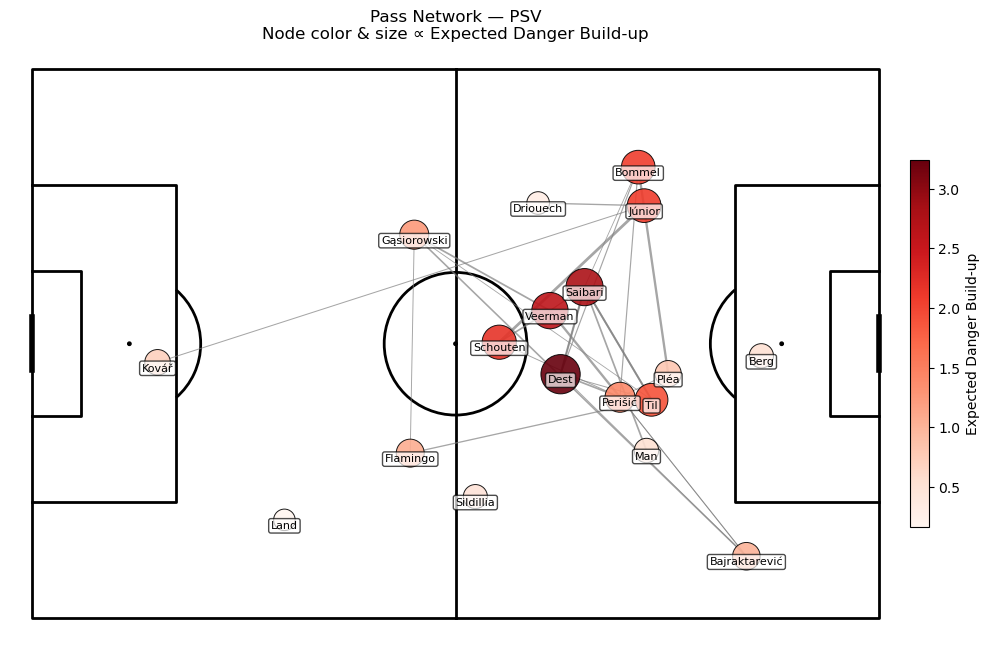

In [39]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

# -------------------------------------------------
# PLOT PASS NETWORK
# -------------------------------------------------
pitch = Pitch(pitch_type='opta', pitch_color='white', line_color='black')
fig, ax = pitch.draw(figsize=(10, 7))

# Normalize values for node sizes + colormap
if not plot_nodes.empty:
    ns = plot_nodes['xd_build'].to_numpy()
    ns_scaled = (ns - ns.min()) / (ns.max() - ns.min() + 1e-9)

    node_sizes = 800 * (0.3 + 0.7*ns_scaled)  # size scaling
    cmap = cm.get_cmap('Reds')                # color scale (low=light red, high=dark red)
    node_colors = cmap(ns_scaled)

    # Draw scatter nodes
    pitch.scatter(
        plot_nodes['x'], plot_nodes['y'],
        s=node_sizes, c=node_colors, ax=ax,
        edgecolors='black', linewidth=0.7, alpha=0.9, zorder=3
    )

    # Annotate names above nodes, with a bounding box
    for _, r in plot_nodes.iterrows():
        ax.text(
            r['x'], r['y'] - 2,  # a bit above node
            str(r['passerName']).split()[-1],  # show last name
            ha='center', va='bottom',
            fontsize=8, zorder=4,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.7)
        )

# Edge widths by xd_build
if not plot_edges.empty:
    ew = plot_edges['xd_build'].to_numpy()
    ew_scaled = (ew - ew.min()) / (ew.max() - ew.min() + 1e-9)
    widths = 2.0 * (0.3 + 0.7*ew_scaled)

    for idx, row in plot_edges.iterrows():
        pkey = (row['passerId'], row['passerName'])
        rkey = (row['receiverId'], row['receiverName'])

        if pkey not in pos_map or rkey not in recv_map:
            continue

        x_start, y_start = pos_map[pkey]
        x_end, y_end = recv_map[rkey]

        pitch.lines(
            x_start, y_start, x_end, y_end, ax=ax,
            lw=widths[plot_edges.index.get_loc(idx)], alpha=0.7,
            color='gray', zorder=2
        )

# Title
ax.set_title(f"Pass Network — PSV\nNode color & size ∝ Expected Danger Build-up", fontsize=12)

# Add colorbar for node danger values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=plot_nodes['xd_build'].min(),
                                                        vmax=plot_nodes['xd_build'].max()))
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label("Expected Danger Build-up")

plt.tight_layout()
out_png = os.path.join(folder_path, f'pass_network_team_{TEAM_FILTER}.png')
fig.savefig(out_png, dpi=300, bbox_inches='tight')
plt.show()


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_1193/2456166634.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


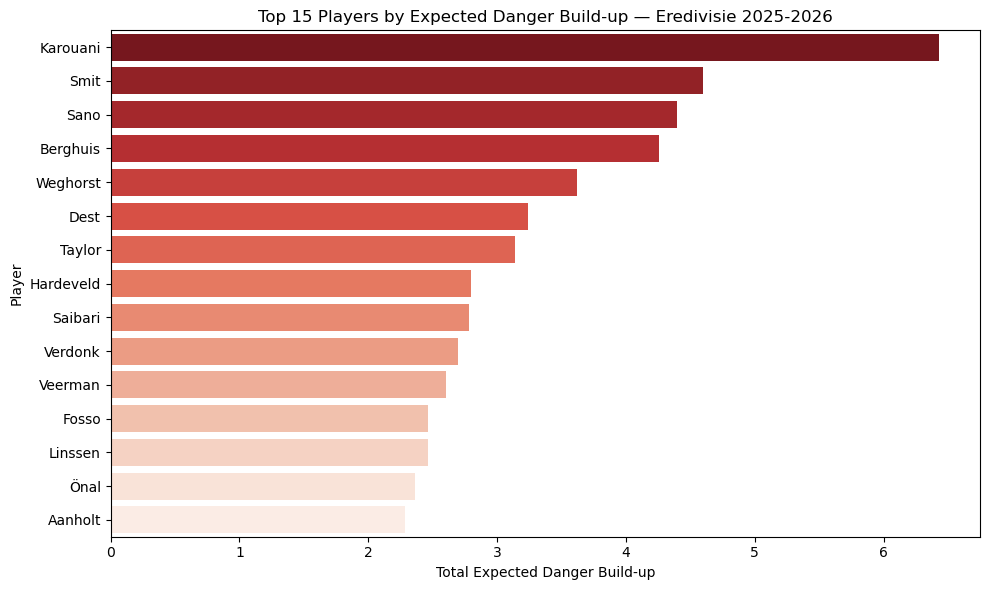

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Top players by expected danger buildup
# -----------------------------
top_nodes = node_positions.sort_values('xd_build', ascending=False).head(15)  # top 15

plt.figure(figsize=(10,6))
sns.barplot(
    x='xd_build', 
    y=top_nodes['passerName'].apply(lambda x: str(x).split()[-1]),  # last name
    data=top_nodes,
    palette='Reds_r'
)

plt.xlabel('Total Expected Danger Build-up')
plt.ylabel('Player')
plt.title(f'Top 15 Players by Expected Danger Build-up — Eredivisie 2025-2026')
plt.tight_layout()
plt.show()


📁 Saved figure to: /Users/user/XG/Eredivisie 2025-2026/S. Berghuis_ShotsMap_purple.png


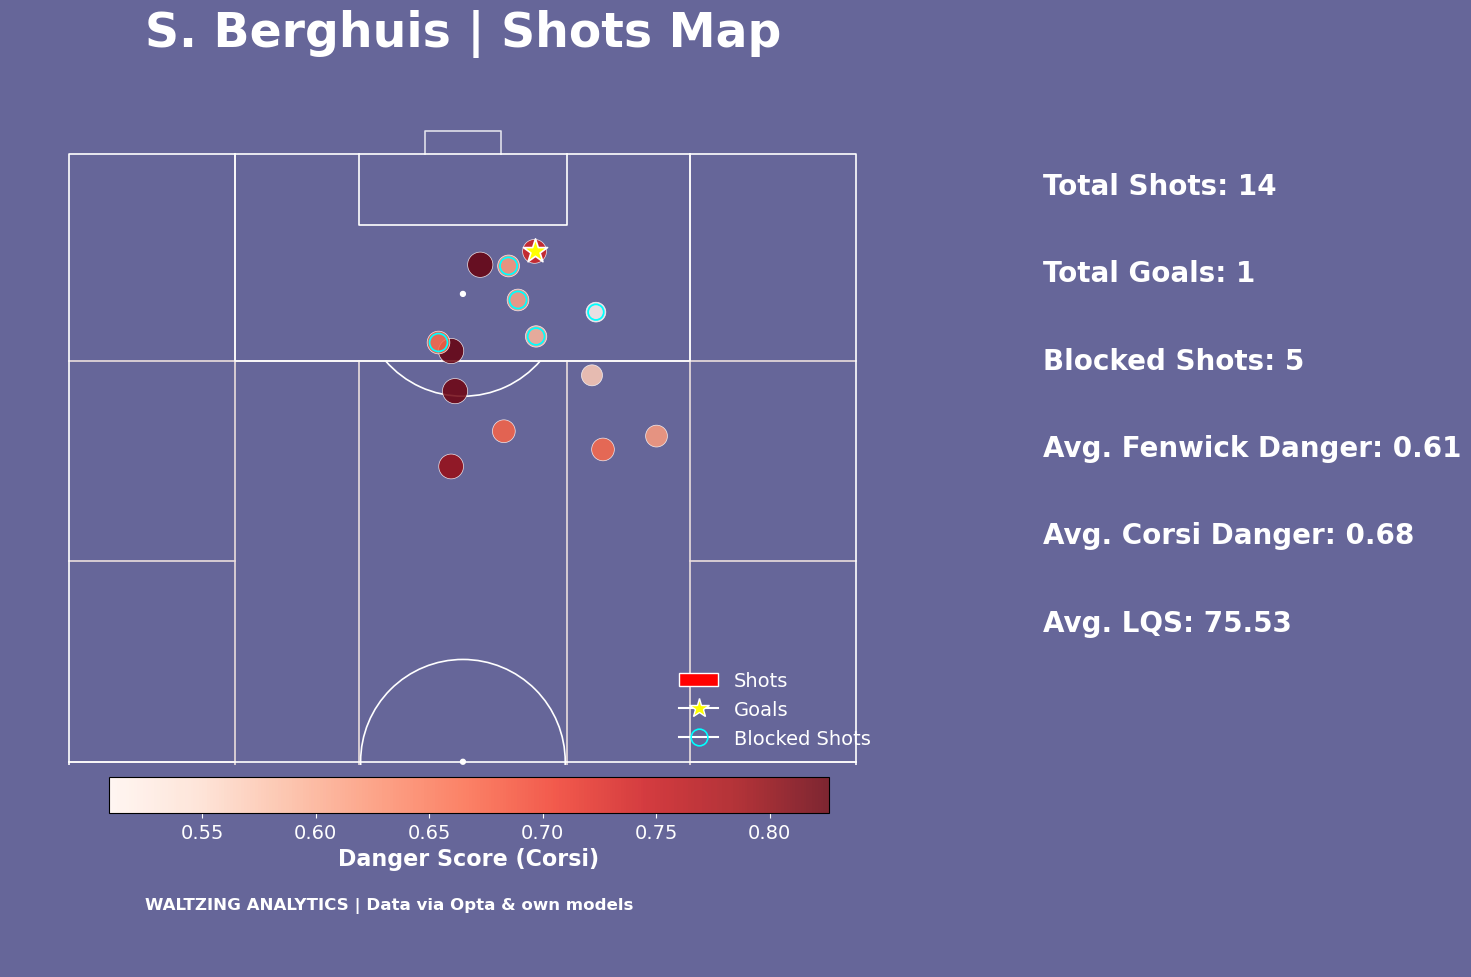

In [56]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# --- File paths ---
folder_path = '/Users/user/XG/Eredivisie 2025-2026'
csv_file_path = os.path.join(folder_path, 'all_matches_with_danger_scores.csv')

# --- Load CSV ---
combined_shots = pd.read_csv(csv_file_path)

# --- Filter for player ---
player_name = 'S. Berghuis'
player_shots = combined_shots[combined_shots['playerName'] == player_name].copy().reset_index(drop=True)

if player_shots.empty:
    print(f"No shots found for {player_name}.")
else:
    # --- Stats ---
    total_shots = len(player_shots)
    total_goals = (player_shots['isGoal'] == True).sum()
    total_blocked = (player_shots['isBlocked'] == True).sum() if 'isBlocked' in player_shots.columns else 0
    avg_fenwick = player_shots['danger_score_fenwick'].mean()
    avg_corsi = player_shots['danger_score_corsi'].mean()
    avg_lqs = ((0.5 * player_shots['inv_distance'] + 0.5 * player_shots['angle_score']).mean()) * 100
    avg_xG_per_shot = player_shots['danger_score_logit'].mean()

    # --- Figure setup ---
    bg_color = "#666699"
    fig = plt.figure(figsize=(18, 12), facecolor=bg_color)
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 0.4], height_ratios=[0.8, 0.2])
    ax_pitch = fig.add_subplot(gs[0, 0], facecolor=bg_color)
    ax_stats = fig.add_subplot(gs[0, 1], facecolor=bg_color)
    ax_cbar = fig.add_subplot(gs[1, 0], facecolor=bg_color)

    # --- Pitch ---
    pitch = VerticalPitch(
        half=True, pitch_type='opta', positional=True,
        pitch_color=bg_color, line_color='white', linewidth=1.2,
        goal_type='box', goal_alpha=0.8
    )
    pitch.draw(ax=ax_pitch)
    ax_pitch.set_ylim(49.7, 105)

    # --- Shots (Corsi danger colormap) ---
    scatter = pitch.scatter(
        player_shots['x'], player_shots['y'],
        s=player_shots['danger_score_corsi'] * 400,
        c=player_shots['danger_score_corsi'],
        cmap='Reds',
        vmin=player_shots['danger_score_corsi'].min(),
        vmax=player_shots['danger_score_corsi'].max(),
        alpha=0.85, edgecolors='white', linewidths=0.5,
        ax=ax_pitch, zorder=2
    )

    # --- Goals (yellow stars) ---
    goals = player_shots[player_shots['isGoal']]
    if not goals.empty:
        pitch.scatter(
            goals['x'], goals['y'],
            s=goals['danger_score_corsi'] * 450,
            c='yellow', marker='*',
            edgecolors='white', linewidths=1.2,
            ax=ax_pitch, zorder=3
        )

    # --- Blocked (cyan outlines) ---
    if 'isBlocked' in player_shots.columns:
        blocked = player_shots[player_shots['isBlocked']]
        if not blocked.empty:
            pitch.scatter(
                blocked['x'], blocked['y'],
                s=blocked['danger_score_corsi'] * 250,
                facecolors='none', edgecolors='cyan',
                linewidths=1.3, ax=ax_pitch, zorder=3
            )

    # --- Stats Panel ---
    ax_stats.axis('off')
    ax_stats.set_ylim(0, 1)
    ax_stats.set_xlim(0, 1)
    stat_color = "white"
    ax_stats.text(0, 0.85, f"Total Shots: {total_shots}", fontsize=20, fontweight='bold', color=stat_color)
    ax_stats.text(0, 0.72, f"Total Goals: {total_goals}", fontsize=20, fontweight='bold', color=stat_color)
    ax_stats.text(0, 0.59, f"Blocked Shots: {total_blocked}", fontsize=20, fontweight='bold', color=stat_color)
    ax_stats.text(0, 0.46, f"Avg. Fenwick Danger: {avg_fenwick:.2f}", fontsize=20, fontweight='bold', color=stat_color)
    ax_stats.text(0, 0.33, f"Avg. Corsi Danger: {avg_corsi:.2f}", fontsize=20, fontweight='bold', color=stat_color)
    ax_stats.text(0, 0.20, f"Avg. LQS: {avg_lqs:.2f}", fontsize=20, fontweight='bold', color=stat_color)

    # --- Colorbar ---
    ax_cbar.axis('off')
    cbar = fig.colorbar(scatter, ax=ax_cbar, orientation='horizontal', shrink=0.7)
    cbar.ax.set_position([0.03, 0.28, 0.7, 0.03])
    cbar.set_label('Danger Score (Corsi)', fontsize=16, weight='bold', color="white")
    cbar.ax.tick_params(labelsize=14, colors="white")

    # --- Legend ---
    legend_elements = [
        Patch(facecolor='red', edgecolor='white', label='Shots'),
        Line2D([0], [0], marker='*', color='w', label='Goals',
               markerfacecolor='yellow', markersize=15, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='w', label='Blocked Shots',
               markerfacecolor='none', markeredgecolor='cyan', markersize=12, markeredgewidth=1.2)
    ]
    ax_pitch.legend(handles=legend_elements, loc='lower right', fontsize=14, frameon=False, labelcolor="white")

    # --- Title & Credits (Left-aligned) ---
    fig.suptitle(f"{player_name} | Shots Map", fontsize=34, weight='bold', y=0.95, color="white", x=0.2, ha='left')
    plt.figtext(0.2, 0.2, "WALTZING ANALYTICS | Data via Opta & own models",
            ha="left", fontsize=12, color='white', fontweight='bold')


    # --- Save & Show ---
    output_path = os.path.join(folder_path, f"{player_name}_ShotsMap_purple.png")
    plt.savefig(output_path, dpi=500, bbox_inches='tight', facecolor=bg_color)
    print(f"📁 Saved figure to: {output_path}")

    plt.show()
